# Gaussian-process regression demo

Here we demonstrate how to use ``inference.gp.GpRegressor`` to perform Gaussian-process regression.

First let's generate some noisy data to fit:

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import exp, sin, sqrt, concatenate, linspace, zeros, meshgrid
from numpy.random import multivariate_normal, normal, random
from inference.gp import GpRegressor

In [2]:
# define a function and use it to create some testing data
def test_function(x):
    return 1. / (1 + exp(-x)) + 0.1*sin(2*x)

N = 24*2
x = concatenate([linspace(-3,1,N//2),linspace(4,9,N//2)])
y = test_function(x)

# add some noise to the data
errors = zeros(N) + 0.05
y += errors*normal(size=N)

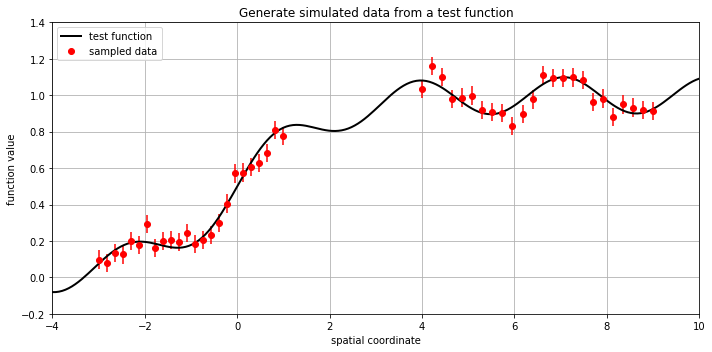

In [3]:
# plot the data points plus the underlying function from which they are sampled
q = linspace(-4, 10, 200)
fig = plt.figure( figsize = (10,5) )
ax = fig.add_subplot(111)
ax.plot(q, test_function(q), lw = 2, color = 'black', label = 'test function')
ax.plot(x, y, 'o', color = 'red', label = 'sampled data')
ax.errorbar(x, y, yerr = errors, fmt = 'none', ecolor = 'red')
ax.set_ylim([-0.2, 1.4])
ax.set_xlim([-4, 10])
ax.set_title('Generate simulated data from a test function')
ax.set_ylabel('function value')
ax.set_xlabel('spatial coordinate')
ax.grid()
ax.legend(loc=2)
plt.tight_layout()
plt.show()

First we need to choose a covariance kernel, which is used to model the spatial structure of the function. The various available kernels are implemented as classes within ``inference.gp``. Here we use the 'squared-exponetial' kernel, implemented as the ``SquaredExponential`` class:

In [4]:
from inference.gp import SquaredExponential

This class, or an instance of it, can be passed to ``GpRegressor`` via the ``kernel`` keyword argument:

In [5]:
# initialise the class with the data and errors
GP = GpRegressor(x, y, y_err = errors, kernel = SquaredExponential)

# call the instance to get estimates for the points in q
mu_q, sig_q = GP(q)

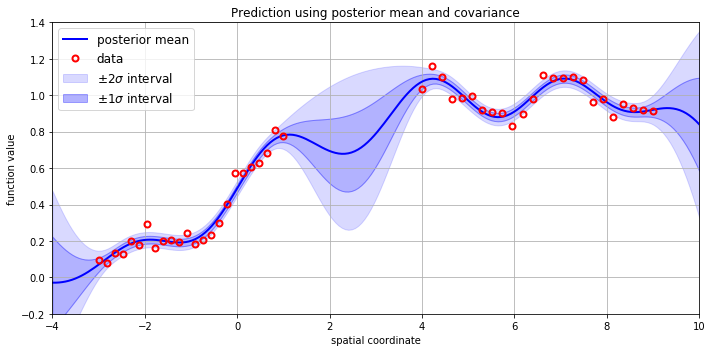

In [6]:
# now plot the regression estimate and the data together
c1 = 'red'; c2 = 'blue'; c3 = 'green'
fig = plt.figure( figsize = (10,5) )
ax = fig.add_subplot(111)
ax.plot(q, mu_q, lw = 2, color = c2, label = 'posterior mean')
ax.fill_between(q, mu_q-sig_q, mu_q-sig_q*2, color = c2, alpha = 0.15, label = r'$\pm 2 \sigma$ interval')
ax.fill_between(q, mu_q+sig_q, mu_q+sig_q*2, color = c2, alpha = 0.15)
ax.fill_between(q, mu_q-sig_q, mu_q+sig_q, color = c2, alpha = 0.3, label = r'$\pm 1 \sigma$ interval')
ax.plot(x, y, 'o', color = c1, label = 'data', markerfacecolor = 'none', markeredgewidth = 2)
ax.set_ylim([-0.2, 1.4])
ax.set_xlim([-4, 10])
ax.set_title('Prediction using posterior mean and covariance')
ax.set_ylabel('function value')
ax.set_xlabel('spatial coordinate')
ax.grid()
ax.legend(loc=2, fontsize = 12)
plt.tight_layout()
plt.show()

As the estimate itself is defined by a multivariate normal distribution, we can draw samples from that distribution.
To do this, we need to build the full covariance matrix and mean for the desired set of points using the `build_posterior()` method:

In [7]:
mu, sigma = GP.build_posterior(q)

# now draw samples
samples = multivariate_normal(mu, sigma, 100)

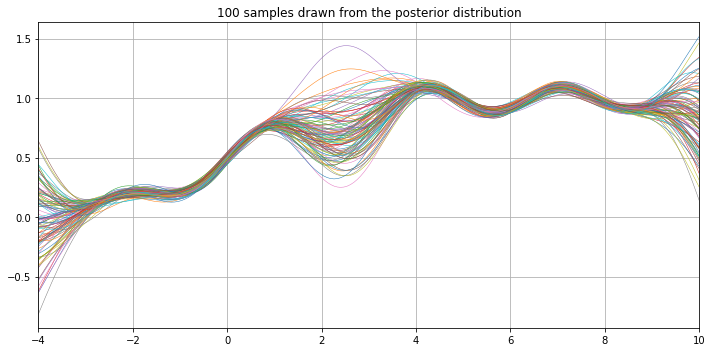

In [8]:
# and plot all the samples
fig = plt.figure( figsize = (10,5) )
ax = fig.add_subplot(111)
for i in range(100):
    ax.plot(q, samples[i,:], lw = 0.5)
ax.set_title('100 samples drawn from the posterior distribution')
ax.set_xlim([-4, 10])
plt.grid()
plt.tight_layout()
plt.show()

The gradient of the Gaussian process estimate also has a multivariate normal distribution.
The mean vector and covariance matrix of the gradient distribution for a series of points can be generated using the ``GP.gradient()`` method:

In [9]:
gradient_mean, gradient_covariance = GP.gradient(q)

# in this example we have only one spatial dimension, so the covariance matrix has size 1x1
sigma = sqrt(gradient_covariance) # get the standard deviation at each point in 'q'

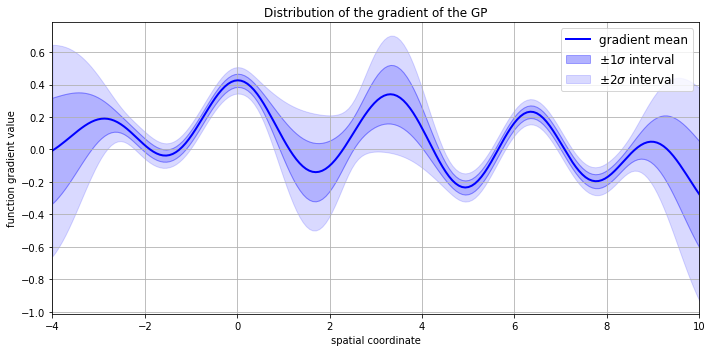

In [10]:
# plot the distribution of the gradient
fig = plt.figure( figsize = (10,5) )
ax = fig.add_subplot(111)
ax.plot(q, gradient_mean, lw = 2, color = 'blue', label = 'gradient mean')
ax.fill_between(q, gradient_mean-sigma, gradient_mean+sigma, alpha = 0.3, color = 'blue', label = r'$\pm 1 \sigma$ interval')
ax.fill_between(q, gradient_mean+sigma, gradient_mean+2*sigma, alpha = 0.15, color = 'blue', label = r'$\pm 2 \sigma$ interval')
ax.fill_between(q, gradient_mean-sigma, gradient_mean-2*sigma, alpha = 0.15, color = 'blue')
ax.set_title('Distribution of the gradient of the GP')
ax.set_ylabel('function gradient value')
ax.set_xlabel('spatial coordinate')
ax.set_xlim([-4, 10])
ax.grid()
ax.legend(fontsize = 12)
plt.tight_layout()
plt.show()

## 2D example

Gaussian-process regression extends naturally to any number of dimensions - here is a 2D example:

In [11]:
# define an 2D function test function
def test_function_2d(v):
    x, y = v
    return sin(x*0.25)+sin(y*0.5)

# Sample the function value at some random points to use as our data
N = 50
coords = random(size=(N,2)) * 15

# evaluate the test function at all points
z = [test_function_2d(v) for v in coords]

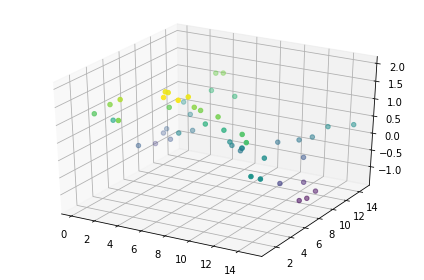

In [12]:
# build a colormap for the points
colmap = cm.viridis((z - min(z)) / (max(z) - min(z)))

# now 3D scatterplot the test data to visualise
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([i[0] for i in coords], [i[1] for i in coords], z, color = colmap)
plt.tight_layout()
plt.show()

In [13]:
# this time use the rational quadratic covariance kernel
from inference.gp import RationalQuadratic

# Train the GP on the data
GP = GpRegressor(coords, z, kernel = RationalQuadratic)

# make a set of axes on which to evaluate the GP estimate
gp_x = linspace(0,15,40)
gp_y = linspace(0,15,40)

# build a coordinate list from these axes
gp_coords = [ (i,j) for i in gp_x for j in gp_y ]

# evaluate the estimate
mu, sig = GP(gp_coords)

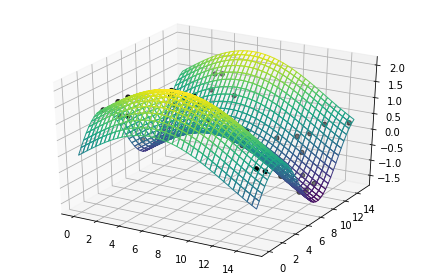

In [14]:
# build a colormap for the surface
Z = mu.reshape([40,40]).T
Z = (Z-Z.min())/(Z.max()-Z.min())
colmap = cm.viridis(Z)
rcount, ccount, _ = colmap.shape

# surface plot the estimate
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(*meshgrid(gp_x, gp_y), mu.reshape([40,40]).T, rcount=rcount,
                       ccount=ccount, facecolors=colmap, shade=False)
surf.set_facecolor((0,0,0,0))

# overplot the data points
ax.scatter([i[0] for i in coords], [i[1] for i in coords], z, color = 'black')
plt.tight_layout()
plt.show()